## IMPORT & LOAD

Avant de commencer nous devons importer les librairies que nous allons utiliser.


In [3]:
#DataFrames
import pandas as pd

import re

# TABS
import numpy as np

# Graphics
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn

# Pour gerer les affichages
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('float_format', '{:f}'.format)

In [3]:
df = pd.read_csv('Data_cars.csv')
df_copy = df

------
# Functions

Pandant cet exercice nous allons avoir besoin d'un certain nombre de fonctions qui seront utiles lors de tâches répétitives.
Exemple : 
- Convertir des champs en type Integer
- Générer des modèles
- Prédrire des données avec le modèle généré
- MAPE : calculer la précision du modèle

In [4]:
#Convert field to Integer
def to_int(df, field):
    _= list(df[field].unique())
    df[field] = df[field].map(lambda x : _.index(x))
    return df
    

In [5]:
# Generate RandomForest Model
def _generate_model(df, selection, y,):
    rf = RandomForestRegressor(n_estimators=200, min_samples_leaf=8, min_samples_split=15, n_jobs=-1, max_depth=8)
    # SPLIT
    X = df[selection]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #TRAIN
    rf.fit(X_train, y_train)
    return rf, X_test ,y_test

In [6]:
def to_predict(df, selection, model, target):
    X = df[selection]
    #Predict
    predicted = model.predict(X)
    #Replace
    df[target]= predicted
    return df

In [7]:
def _mape(y_test, y_pred):
    N = len(y_pred)
    mape = (1/N) * sum(abs((y_test - y_pred)/y_test)) * 100
    return mape

_______
# Observations Globale

La première chose à effectuer pour commencer, est d'observer les données brutes.
Nous pouvons remarquer : 
- `166695` lignes et `9` colonnes
- Parmi celles-ci il y 7 colonnes `Object`,  1 colonne `float` et 1 colonne `integer`

Pour pouvoir concevoir un modèle capable de prédire le `Price`, nous allons devoir convertir chacune de ces variables en `Integer` ou `Float`

In [8]:
df_copy.shape

(166695, 9)

In [9]:
df_copy.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.000000,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.000000,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.000000,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.000000,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.000000,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        166695 non-null  float64
 1   Make         166695 non-null  object 
 2   Model        166695 non-null  object 
 3   Model_year   166695 non-null  int64  
 4   Mileage      166695 non-null  object 
 5   Fuel         166695 non-null  object 
 6   Gearbox      166695 non-null  object 
 7   Online       166695 non-null  object 
 8   Description  166695 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ MB


_______

# Convertir les variables en INT

##### `Mileage` : supprimer le `km` et convertir en `integer`

In [11]:
df_copy['Mileage'] = [int(float(km[:-3])) for km in df_copy['Mileage'] ]

##### `Price` : convertir en `integer`

In [12]:
df_copy['Price'] = [int(float(price)) for price in df_copy['Price'] ]

In [13]:
df_copy.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220,PEUGEOT,308,2014,94341,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526,BMW,X6,2015,39051,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379,AUDI,RS6,2014,75381,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830,FORD,KA,2007,92282,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925,FIAT,TIPO,2018,10,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


_____
# Observations statistic

In [14]:
price = df_copy[['Price', 'Mileage']]
price.describe()

,Price,Mileage
count,166695.000000,166695.000000
mean,19333.694580,46894.043565
std,16420.342104,48210.072767
min,1.000000,1.000000
25%,11280.000000,9169.500000
50%,15774.000000,30485.000000
75%,22707.500000,73357.000000
max,1486500.000000,1418551.000000


### Observations :
-  `Price`
    - nous constatons que le prix minimum est de `1€` et le maximum est de `1 486 500€`.  Cela mérite une une observation approfondie.
    

- `Mileage`
    - kilomètre minimum  = `1 km`
    
    -  Kilomètre maximum =  `1 418 551 km`
    -  Est-ce possible qu'une voiture puisse faire autant de chemin ? Nous allons creuser.

- Important : 3/4 des véhicules ont moins de `75000km` et coute moins de `23000€`

Nous devons faire en sorte que nos données n'aient pas de outliers, car ces derniers peuvent fausser le résultat du modèle de prédiction.

_____
# Exploration de la variable `Price`

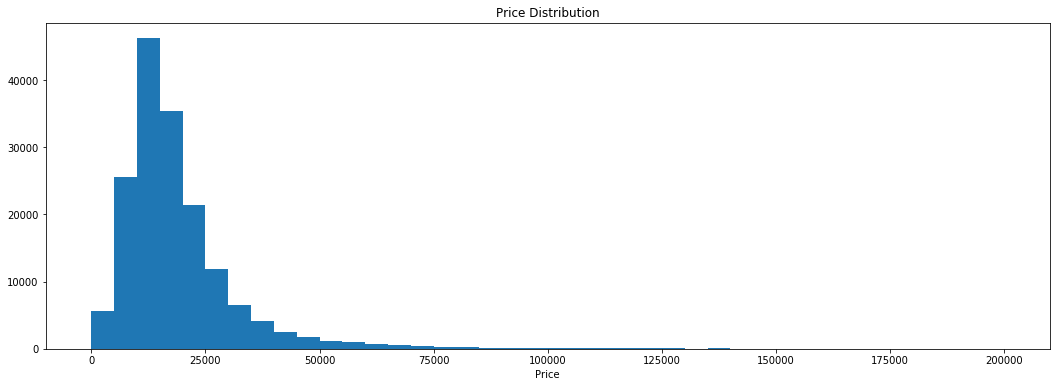

In [15]:
plt.figure(figsize=(18,6))
n, bins, patch = plt.hist(df_copy['Price'],bins=40, range=(0,200000), label='Price Distribution')
plt.xlabel("Price")
plt.title('Price Distribution')
plt.show()

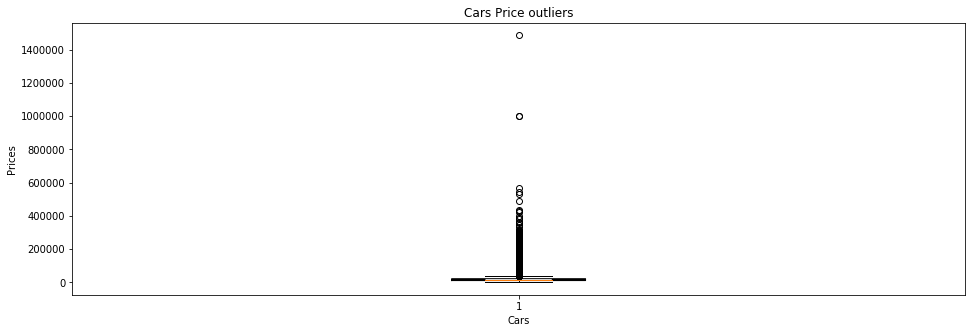

In [16]:
plt.figure(figsize=(16,5))
plt.boxplot(df_copy['Price'], notch=True)
plt.xlabel("Cars")
plt.ylabel("Prices")
plt.title("Cars Price outliers")
plt.show()

In [17]:
low_cost = df_copy[df_copy['Price'] < 400]
low_cost

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
1817,303,PEUGEOT,206,2000,232650,Essence,mécanique,06/06/2018 à 13h40,"modele: 206, version: 1.1 XR PRESENCE 5P, puis..."
13515,301,VOLKSWAGEN,GOLF,2003,332816,Diesel,mécanique,16/06/2018 à 10h46,"modele: GOLF 4, version: IV TDI 100 MATCH 4MOT..."
23838,1,AUDI,S5,2017,14413,Essence,mécanique,17/05/2018 à 9h34,"modele: S5 SPORTBACK (2E GENERATION), version:..."
30085,101,HYUNDAI,IX35,2013,107400,Diesel,mécanique,11/04/2018 à 5h41,"modele: IX35, version: 1.7 CRDI 115 PACK EDITI..."
67849,350,TOYOTA,COROLLA,1999,112214,Essence,mécanique,05/06/2018 à 9h39,"modele: COROLLA 8, version: VIII 1.3 I GS 3P, ..."
70310,1,RENAULT,TWINGO,1998,221540,Essence,mécanique,13/05/2018 à 6h50,"modele: TWINGO, version: 1.2 ALIZE, puissance_..."
77128,1,VOLKSWAGEN,GOLF,2001,117177,Diesel,mécanique,24/05/2018 à 11h29,"modele: GOLF 4, version: IV TDI 115 CONFORT PL..."
90574,303,PEUGEOT,106,1999,201925,Essence,mécanique,19/06/2018 à 21h39,"modele: 106, version: (2) 1.4 COLOR LINE 3P, p..."
119052,1,CITROEN,GRAND C4 PICASSO,2015,134459,Diesel,automatique,30/08/2018 à 14h23,"modele: GRAND C4 PICASSO 2, version: II 1.6 BL..."
138593,338,RENAULT,MEGANE,2002,221286,Diesel,mécanique,07/05/2018 à 13h30,"modele: MEGANE, version: 5P DIESEL, puissance_..."



### Observations

- Les Prix des véhicules sont majoritairement compris entre `0` et `50000`
- Les Prix des véhicules ont de nombreuses valeurs aberantes qui constrastent énormément avec les valeurs mesurées.

Voici quelques exemples de données aberantes: 

```
Price : 1$   AUDI	    S5	    2017
Price : 101$  HYUNDAI	    IX35	     2013	
Price : 1$    CITROEN	    GRAND C4 PICASSO	2015
Price : 176$  WOLKSWAGEN	  NEW BEETLE 	2015
Price : 250$  PEUGEOT	      308	2010
```
Pour répondre à ce problème nous devons encadrer les données afin d'avoir  un dataset sans valeurs aberantes. 
Pour cela nous allons filtrer le DataSet pour garder uniquement les véhicules entre `400` et `125000`

#### Filtrage des données `Price`

In [18]:
df_copy = df_copy[ (400 < df_copy['Price']) & (df_copy['Price'] < 125000)]

----

# Exploration de la variable `Mileage`

Nous allons maintenant nous occuper de la variables `Maliage`, qui donne référence aux kilomètres parcouru par les véhicules.

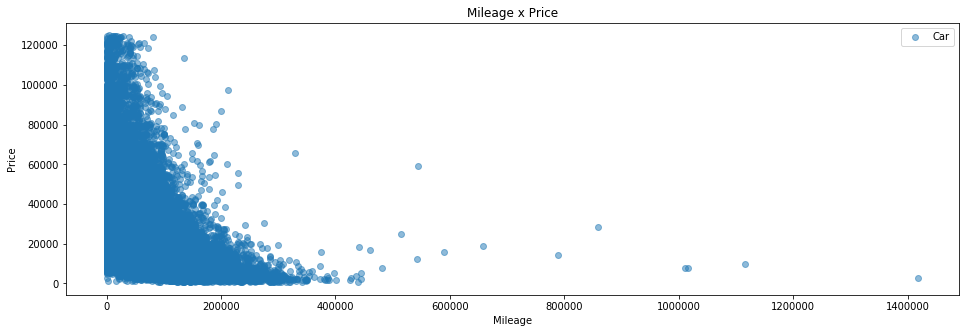

In [19]:
plt.figure(figsize=(16,5)) # DEBUT DE FINGURE
plt.scatter(df_copy['Mileage'],df_copy['Price'], alpha=0.5, label="Car")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Mileage x Price")
plt.legend()
plt.show()

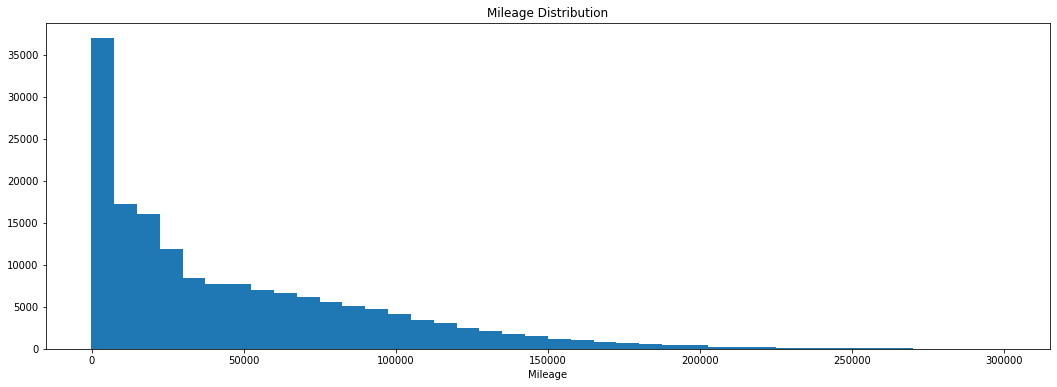

In [20]:
plt.figure(figsize=(18,6))
plt.hist(df_copy['Mileage'],bins=40, range=(-100,300000), label='Mileage Distribution')
plt.xlabel("Mileage")
plt.title('Mileage Distribution')
plt.show()

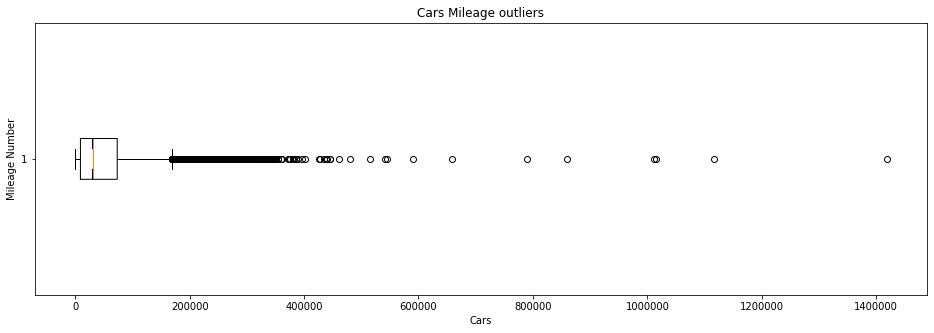

In [21]:
plt.figure(figsize=(16,5))
plt.boxplot(df_copy['Mileage'], vert=False,notch=True)
plt.xlabel("Cars")
plt.ylabel("Mileage Number")
plt.title("Cars Mileage outliers")
plt.show()

In [22]:
df_copy[(df_copy['Mileage'] > 300000) & (df_copy['Model_year'] > 2010) ]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
12816,16789,CITROEN,C4 AIRCROSS,2016,460523,Diesel,mécanique,14/10/2018 à 22h21,"modele: C4 AIRCROSS, version: 1.6 HDI 115 S&S ..."
24668,6008,SKODA,SUPERB,2012,336260,Diesel,automatique,13/05/2018 à 10h21,"modele: SUPERB 2 COMBI, version: II (2) COMBI ..."
26374,3786,PEUGEOT,508,2011,385950,Diesel,mécanique,01/08/2018 à 4h14,"modele: 508, version: 2.0 HDI FAP 140 BUSINESS..."
27186,18800,AUDI,A3,2014,658839,Diesel,automatique,20/04/2018 à 14h37,"modele: A3 (3E GENERATION) BERLINE, version: I..."
54549,7968,CITROEN,C4,2012,1015653,Diesel,mécanique,10/03/2018 à 13h24,"modele: C4 (2E GENERATION), version: 1.6 HDI 1..."
69481,6393,SKODA,OCTAVIA,2014,359432,Diesel,automatique,16/08/2018 à 6h41,"modele: OCTAVIA 2, version: II (2) 1.6 TDI 105..."
93013,15705,MERCEDES,CLASSE CLS,2012,374661,Diesel,automatique,16/08/2018 à 21h33,"modele: CLASSE CLS 2, version: II 350 CDI BLUE..."
98672,9910,MERCEDES,CLASSE B,2011,1116757,Diesel,mécanique,13/03/2018 à 13h40,"modele: CLASSE B, version: (2) 180 CDI DESIGN,..."
102996,14314,PEUGEOT,3008,2014,789216,Diesel,mécanique,16/05/2018 à 17h43,"modele: 3008, version: 1.6 HDI 115 FAP ALLURE,..."
106299,9547,AUDI,A6,2012,302091,Diesel,automatique,13/04/2018 à 1h48,"modele: A6 (4E GENERATION) AVANT, version: IV ..."


### Observations de `Mileage`

1. Beaucoup de véhicules ont un nombre de kilomètres suppérieurs à `300 000 km`
2. La majorité des données abérantes sont situé au-dessus de `200 000km`
3. Certains des véhicules abérant ont un kilomètre excessivement élevé et un prix tout aussi important. Exemple : 

``` 
 row :   27186	Price: 18800	KM: 	658839
 row :  107367	Price: 24665	KM: 	515115
 row :  119458	Price: 28428	KM: 	859122
```

4. La variable `Mileage` a des données avec beaucoup d'écart. Il est important de normaliser ces données afin de réduire la compléxité des données. La normalisation est une méthode de prétraitement des données qui permet de réduire cette complexité pour les  modèles.


### Filtrage de `Mileage`

Suppression des données à moins de `200000km` pour uniformiser le dataset.


In [23]:
df_copy = df_copy[ df_copy['Mileage'] < 200000]

### Normalization `Mileage`


In [24]:
mileage_max =df_copy['Mileage'].max()
mileage_min = df_copy['Mileage'].min()

In [25]:
df_copy['Mileage']=df_copy['Mileage'].map(lambda x: (x - mileage_min)/ (mileage_max - mileage_min))

________
# Explore Cars `MODEL_YEAR`

`Modele_year` référence la date de mise en service des véhicule. 
Nous allons pouvoir analyser le la distribution de ces dates.

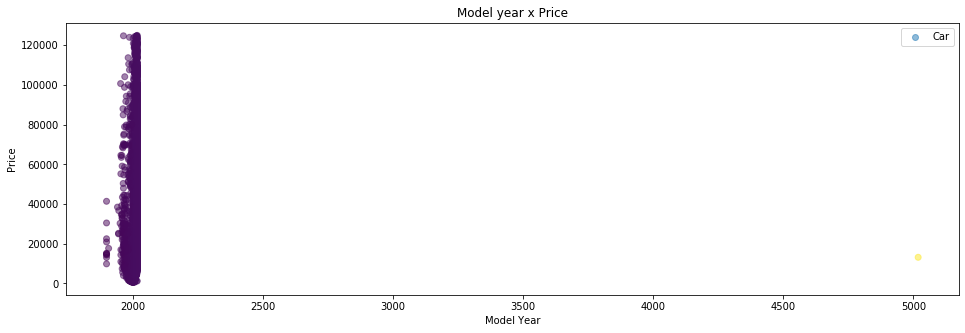

In [26]:
plt.figure(figsize=(16,5)) # DEBUT DE FINGURE
plt.scatter(df_copy['Model_year'],df_copy['Price'], c=df_copy['Model_year'], alpha=0.5, label="Car")
# c = gère la coleur
# alpha = transparence
# s = taille de points
plt.xlabel("Model Year")
plt.ylabel("Price")
plt.title("Model year x Price")
plt.legend()
plt.show()

###  Voiture du futur : 
Ce véhicule semble avoir une date bien trop futuriste. Nous allons supprimer cette date aberrante.

In [27]:
df_copy[(df_copy['Model_year'] > 2020)]

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
17541,13159,FIAT,500,5018,0.014862,Diesel,mécanique,02/05/2018 à 6h54,"modele: , version: LOUNGE 1.2 69, puissance_fi..."


In [28]:
df_copy = df_copy[(df_copy['Model_year'] < 2020)]

### Distribution des véhicules
Voici la distribution réelle du dataset.
Nous pouvons remarquer que la majorité des véhicules présents dans le DataSet ont une date de mise en service inférieur à `2000`.

Nous allons grace à la colonne `Modele_year` pouvoir calculer l'`Age` des véhicules que nous utiliserons pour effectuer un filtre sur l'ensemble du dataset et pour pouvoir recadrer les données.

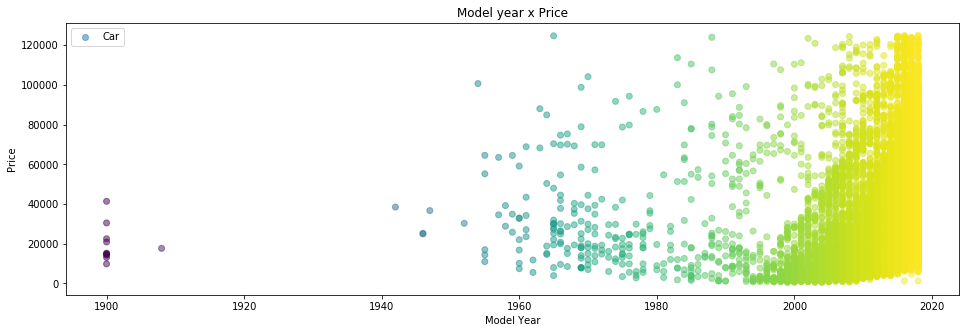

In [29]:
plt.figure(figsize=(16,5)) # DEBUT DE FINGURE
plt.scatter(df_copy['Model_year'],df_copy['Price'], c=df_copy['Model_year'], alpha=0.5, label="Car")
plt.xlabel("Model Year")
plt.ylabel("Price")
plt.title("Model year x Price")
plt.legend()
plt.show()


### Outliers `Model_years` :

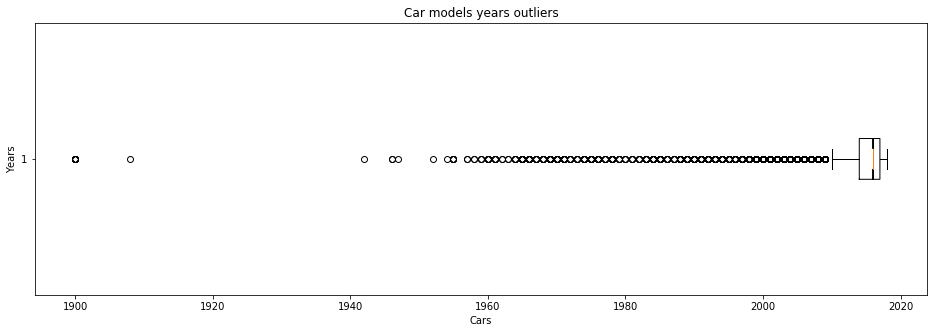

In [30]:
plt.figure(figsize=(16,5))
plt.boxplot(df_copy['Model_year'], vert=False,notch=True)
plt.xlabel("Cars")
plt.ylabel("Years")
plt.title("Car models years outliers")
plt.show()

In [31]:
old_cars = df_copy[(df_copy['Model_year'] < 2000)]
old_cars

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
721,7432,FIAT,1200,1960,0.310168,Essence,mécanique,30/08/2018 à 19h46,"modele: 1200, version: SPYDER, puissance_fisca..."
908,16054,PORSCHE,BOXSTER,1997,0.751514,Essence,mécanique,08/09/2018 à 12h46,"modele: BOXSTER TYPE 986, version: 2.5 204, pu..."
1475,4653,SUZUKI,VITARA,1999,0.871266,Diesel,mécanique,01/10/2018 à 6h26,"modele: VITARA, version: CABRIOLET 1.9 TD JLX ..."
1587,1239,FIAT,UNO,1989,0.437236,Essence,mécanique,28/02/2018 à 0h45,"modele: UNO, version: 60 S 5P, puissance_fisca..."
1592,34224,MG,A,1961,0.483676,Essence,mécanique,29/04/2018 à 19h25,"modele: A, version: CABRIOLET 1.6, puissance_f..."
...,...,...,...,...,...,...,...,...,...
165435,39381,PORSCHE,911,1971,0.400172,Essence,mécanique,15/06/2018 à 20h31,"modele: 911 TYPE 901, version: 2.2 E, puissanc..."
166015,36682,MG,TC,1947,0.024643,Essence,mécanique,13/05/2018 à 22h31,"modele: TC, version: E, puissance_fiscale: 7, ..."
166470,80060,FERRARI,F355,1996,0.335665,Essence,mécanique,15/09/2018 à 7h24,"modele: F355, version: 3.5 BERLINETTE BV6, pui..."
166536,77977,PORSCHE,911,1985,0.682177,Essence,mécanique,21/03/2018 à 21h18,"modele: 911 TYPE 930, version: (930) TURBO 3.3..."


In [32]:
df_copy['Model_year'].describe()

count   164661.000000
mean      2014.677185
std          3.712565
min       1900.000000
25%       2014.000000
50%       2016.000000
75%       2017.000000
max       2018.000000
Name: Model_year, dtype: float64

### Comme nous pouvons le constater, 
 
- la majorité des données aberrantes dans présente dans la variable `Modele_year` sont des données dont la date de mise en service est inférieure à 2005.
- Nous n'allons pas supprimer ces aberrations maintenant, nous allons attendre de calculer l'âge des véhicules pour le faire.

______

# Exploration de `Gearbox`

Nous allons maintenant analyser les données `Gearbox` qui référence le type de boîte de vitesse par véhicule : `automatique ` ou `mécannique`

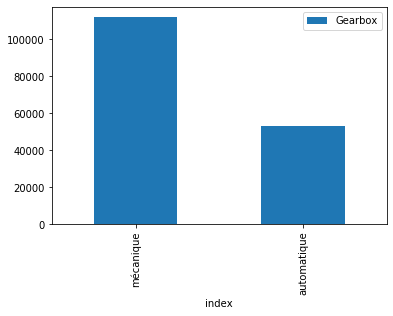

In [33]:
gearbox = pd.DataFrame(df_copy['Gearbox'].value_counts())
gearbox = gearbox.reset_index()
gearbox.plot.bar(x='index', y='Gearbox')


In [34]:
df_copy['Gearbox'] = df_copy['Gearbox'].str.upper()

### Dummyfication de `Gearbox`

In [35]:
gearbox = pd.get_dummies(df_copy['Gearbox'], prefix='gearbox', columns=['auto, meca'])
gearbox = gearbox.rename(columns={"gearbox_automatique": "gearbox_auto", "gearbox_mécanique": "gearbox_meca"})
gearbox.head()

,gearbox_AUTOMATIQUE,gearbox_MÉCANIQUE
0,0,1
1,1,0
2,1,0
3,0,1
4,0,1


### Observations :

1. Nous pouvons constater que 2/3 des véhicules sont mécaniques et 1/3 sont automatiques
2. Pour optimiser au mieux le modèle nous allons devoir `Dummifier` les données et créer pour chaque catégorie une colonne qui référencera par `1=True` ou `0=False`
 si le véhicule à le mécanisme en question


### Dummification

In [36]:
df_copy['gearbox_auto'] = gearbox['gearbox_AUTOMATIQUE']
df_copy['gearbox_meca'] = gearbox['gearbox_MÉCANIQUE']

______

# Exploration de `Fuel` 

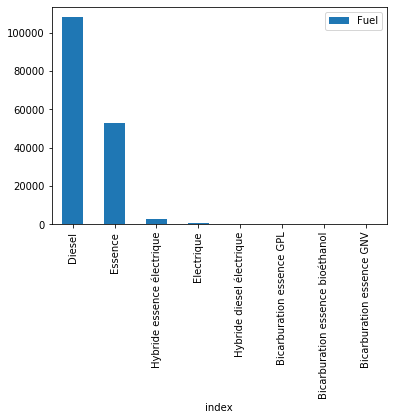

In [37]:
fuel = pd.DataFrame(df_copy['Fuel'].value_counts())
fuel = fuel.reset_index()
fuel.plot.bar(x='index', y='Fuel')

### Dumyfication `Fuel`

In [38]:
fuel = pd.get_dummies(df_copy['Fuel'], prefix='Fuel')


In [39]:
fuel =fuel.rename(columns={"Fuel_Bicarburation essence GNV": "Fuel_GNV",
                     "Fuel_Bicarburation essence GPL" :  "Fuel_GPL",
                     "Fuel_Bicarburation essence bioéthanol" : "Fuel_ethanol",
                     "Fuel_Diesel": "Fuel_diesel",
                     "Fuel_Electrique" : "Fuel_elec",
                     "Fuel_Essence" : "Fuel_essence",
                     "Fuel_Hybride diesel électrique" : "Fuel_hybrid_diesel_elect",
                     "Fuel_Hybride essence électrique" :  "Fuel_hybrid_essence_elect"})

In [40]:
df_copy['Fuel_GNV'] = fuel['Fuel_GNV']
df_copy['Fuel_GPL'] = fuel['Fuel_GPL']
df_copy['Fuel_ethanol'] = fuel['Fuel_ethanol']
df_copy['Fuel_diesel'] = fuel['Fuel_diesel']

df_copy['Fuel_elec'] = fuel['Fuel_elec']
df_copy['Fuel_essence'] = fuel['Fuel_essence']
df_copy['Fuel_hybrid_diesel_elect'] = fuel['Fuel_hybrid_diesel_elect']
df_copy['Fuel_hybrid_essence_elect'] = fuel['Fuel_hybrid_essence_elect']


### Convert `Fuel` to  0 or 1

In [41]:
fuel = list(df_copy['Fuel'].unique())
df_copy['Fuel'] = df_copy['Fuel'].map(lambda x : fuel.index(x))

______
## `DESCRIPTION` VARIABLE

`Description` est une variable dans lequel nous avons de nombreuses informations qui peuvent être pertinentes pour le modèle.

Nous allons extraire de cette variable les informations suivantes : Version, Portes, Cylindre, Puissance Fiscale, Couleurs, Options...

In [42]:
# HANDLE COLORS
df_copy['Colors'] = df_copy['Description'].map(lambda x : re.split(r'couleur: ', x.lower())[-1])
df_copy = to_int(df_copy, 'Colors')

In [43]:
# HANDLE VERSIONS
df_copy['Versions'] = df_copy['Description'].map(lambda x : re.search(r'version: (.*?), puissance_fiscale', x).group(1))

In [44]:
# HANDLE POWER
df_copy['Power'] = df_copy['Description'].map(lambda x : re.search(r'puissance_fiscale: (.*?), portes', x).group(1))
df_copy['Power'] = df_copy['Power'].map(lambda x : int(x))

In [45]:
# HANDLE DOORS
df_copy['Doors'] = df_copy['Description'].map(lambda x : re.search(r'portes: (.*?), options', x).group(1))
df_copy['Doors'] = df_copy['Doors'].map(lambda x: 0 if(x=='') else int(x[:-2]) )

In [46]:
df_copy['Gearbox'] = df_copy['Gearbox'].str.upper()

_______
## `Online`

La variable `Online` contient les informations de mise en ligne du véhicule. Malheureusement le format d'enregistrement n'est pas compréhensible pour le modèle.

Nous devons donc trouver un moyen de pouvoir rendre ces données exploitables par le modèle.

J'ai choisi d'extraitre de ce champs : les années, les mois, et les jours dans des champs différents

In [47]:
online_dates = pd.to_datetime(df_copy['Online'], format='%d/%m/%Y à %Hh%M')

In [48]:
df_copy['Online_year'] = online_dates.dt.year

In [49]:
df_copy['Online_month'] = online_dates.dt.month

In [50]:
df_copy['Online_days'] = online_dates.dt.day

_____
## `Ages`

Grâce au champs `Online_years` que nous avons précédement extrait nous allons pouvoir calculer l'âge de chaque véhicule.
Cette information peut être pertinente pour modèle et ainsi améliorer les prédictions de notre modèle.

In [51]:
df_copy['Ages'] = df_copy['Online_year'] - df_copy['Model_year']

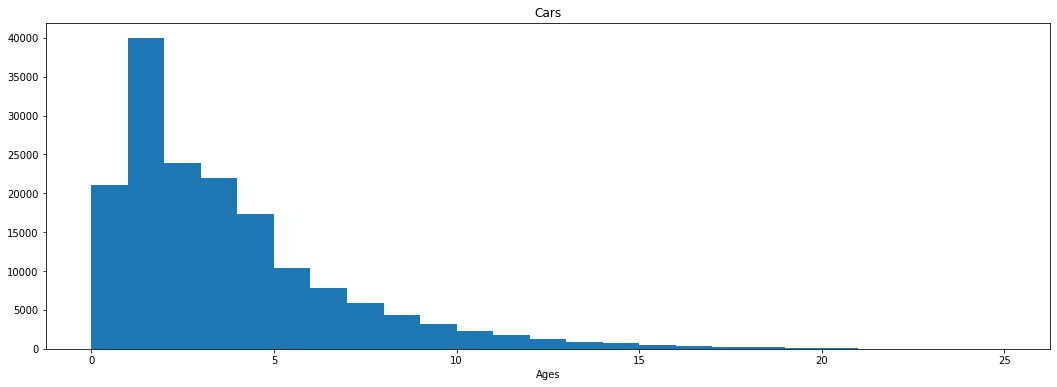

In [52]:
plt.figure(figsize=(18,6))
plt.hist(df_copy['Ages'],bins=25, range=(0,25), label='Ages Distribution')
plt.xlabel("Ages")
plt.title('Cars')
plt.show()

In [53]:
df_copy['Ages'].describe()

count   164661.000000
mean         3.322815
std          3.712565
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        118.000000
Name: Ages, dtype: float64

### Observation de `Ages`
Les 3/4 des véhicules ont moins de `4 ans`. 
Le futur modèle ayant pour but aussi de prédire le prix des véhicules ayant un âge avancé nous allons filtrer les données 15 ans et supprimer les voitures au-delà. 


In [54]:
df_copy = df_copy[(df_copy['Ages'] < 15)]

______
#  Variable `VERSIONS` :`Cylinder` & `Horses`


La variable `Versions` détient un certain nombre d'informations intéréssantes que nous pouvons extraire: 
- Les Cylindres et les Chevaux. Ces derniers peuvent avoir une forte corrélation avec le prix. Nous allons essayer de créer deux nouveaux champs: `Cylinder` & `Horses`
- Nous allons ensuite analyses ces nouvelles données afin de vérifier s'il y a des données manquantes. 

In [55]:
# Extract Cylinders
df_copy['Cylinder'] = df_copy['Versions'].str.extract(r'(\d+\.\d)', flags=0, expand=True).astype(float)

In [56]:
# Extract Horses
df_copy['Horses'] = df_copy['Versions'].str.extract('( \d+ |\d+CH)',  flags=0, expand=True)
df_copy['Horses'] =  df_copy['Horses'].str.extract('(\d+)',  flags=0, expand=True)

______
## Ségmenter les données pour trouver les données `Cylinder` & `Horses` manquantes

In [57]:
df_copy.shape

(162738, 29)

______

# Analyse de `Cylinder`

Analysons maintenant ce que contient la nouvelle variables `Cylinder`

In [58]:
# Données Manquantes et présentes
df_copy['Versions'].str.contains(r'(\d+\.\d+)').value_counts()

True     133806
False     28932
Name: Versions, dtype: int64

In [59]:
has_cylinder = df_copy[df_copy['Cylinder'].isna()==False ]

In [60]:
# Statistiques des données Cylindre
pd.DataFrame(has_cylinder['Cylinder'].astype(float).describe())

,Cylinder
count,133806.000000
mean,1.589883
std,0.767664
min,0.600000
25%,1.300000
50%,1.600000
75%,1.600000
max,87.400000


In [61]:
# Marques de véhicules ayant le plus de manqutes de données
df_copy[ df_copy['Cylinder'].isna()==True]['Make'].value_counts().head()

BMW         8949
MERCEDES    8021
TOYOTA      3311
CITROEN     1888
VOLVO       1390
Name: Make, dtype: int64

In [62]:
df_copy[ df_copy['Cylinder'].isna()==True]['Model'].value_counts().head()

SERIE 1     1728
CLASSE A    1564
CLASSE C    1517
SERIE 3     1500
YARIS       1296
Name: Model, dtype: int64

### Observations:

- `NaN`  : Nous constatons que plus de `28932` véhicules n'ont pas de Cylindres de renseignés.
- Nous pouvons constater que la `moyenne` des cylindres renseignés est de `1.60`. L'écart type moyen est de `0,89` entre chaque véhicule.
- `Données abérantes` : nous constatons que le max est de `87.4`. Cela doit être une erreur de saisie. Nous allons supprimer les données ayant un cylindre supérieure à 7.
- Nous allons devoir analyser quel type de véhicule n'a pas de Cylindre pour pouvoir trouver une solution qui peut combler ce manque.


----
# Analyse de `Horses`

In [63]:
# Valeurs manquantes pour Horses
df_copy['Horses'].isna().value_counts()

False    148149
True      14589
Name: Horses, dtype: int64

In [64]:
# Marques concernée par les données manquantes
df_copy[ df_copy['Horses'].isna()==True]['Make'].value_counts().head()

BMW         2707
MERCEDES    2200
TOYOTA      2023
PEUGEOT      875
RENAULT      722
Name: Make, dtype: int64

In [65]:
df_copy[ df_copy['Horses'].isna()==True]['Model'].value_counts().head()

SERIE 1    918
SERIE 2    780
GLA        644
YARIS      547
AURIS      520
Name: Model, dtype: int64

In [66]:
# Enregistrement des rows manquantes pour les prédire dans les  modèles des étapes suivantes
not_horses = df_copy[df_copy['Horses'].isna()==True]

In [67]:
# Enregistrement des rows présente pour l'entraintement des futurs modèles
has_horses = df_copy[(df_copy['Horses'].isna()==False)]
has_horses['Horses']= has_horses['Horses'].astype(int)

#### Observation : 
- `14583` véhicules n'ont pas de chevaux renseignés. 
- Les marques de véhicules présentant ces absences de saisies sont les mêmes que celles de Cylindres.
- Afin d'avoir un modèle performant, nous allons devoir trouver un moyen de récupérer ces données manquantes.
- Pour cela deux choix s'offre à nous :
    1. Scrapper un SiteWeb ayant ces informations.
    2. Prédire ces manques grâce à un modele
    
    
La solution que j'ai choisis est la 2. Je vais grâce à un modèle `RandomForestRegressor` prédire les données manquantes.

_____
## Preparation de `Cylinder ` et `Horses` à la prédiction.

In [68]:
# No Cylinders and Horses
no_cylinder_and_horse = df_copy[(df_copy['Cylinder'].isna()==True)  & (df_copy['Horses'].isna()==True)]
no_cylinder_and_horse = to_int(no_cylinder_and_horse, 'Model')
no_cylinder_and_horse = to_int(no_cylinder_and_horse, 'Make')
no_cylinder_and_horse.shape

(9028, 29)

In [69]:
no_cylinder_and_horse.shape

(9028, 29)

In [70]:
# No cylinder but horses
no_cylinder_has_hors = df_copy[df_copy['Cylinder'].isna() & ( df_copy['Horses'].isna() ==False )]
no_cylinder_has_hors = to_int(no_cylinder_has_hors, 'Make')
no_cylinder_has_hors = to_int(no_cylinder_has_hors, 'Model')
no_cylinder_has_hors.shape

(19904, 29)

In [71]:
no_cylinder_has_hors.shape

(19904, 29)

In [72]:
# Cylinder but not Horses
has_cyl_no_hors  = df_copy[( df_copy['Cylinder'].isna()==False) & ( df_copy['Horses'].isna())]
has_cyl_no_hors  = to_int(has_cyl_no_hors , 'Make')
has_cyl_no_hors  = to_int(has_cyl_no_hors , 'Model')
has_cyl_no_hors.shape

(5561, 29)

In [73]:
has_cyl_no_hors.shape

(5561, 29)

In [74]:
complete = df_copy[(df_copy['Cylinder'].isna()==False) & (df_copy['Horses'].isna()==False)]
complete  = to_int(complete , 'Make')
complete  = to_int(complete , 'Model')
complete.shape

(128245, 29)



### Observations :
D'après les données que nous avons ici. 
Les véhicules qui n'ont pas de Cylindrés et de chevaux  de renseigné sont majoritairement de marque `BMW`, `Mercedes` et `Toyota`.

Ces données étant importantes pour le modèle, nous les avons ségmentées de manière suivante : 

1. `no_cylinder_and_horse`     pour `Cylinder=False`  &  `Horses=False` 
2. `no_cylinder_has_hors`  pour `Cylinder=False`  &  `Horses=True` 
3. `has_cyl_no_hors`  pour `Cylinder=True`  &  `Horses=False` 
4. `complete`           pour `Cylinder=True`  &  `Horses=True` 


Nous avons besoin de cette segmentation pour prédire les données manquantes avec un modele de Machine Learning.

___
# Variable `Makes`
Analysons avant cela, la fréquence de chaque véhicule dans l'ensemble du dataset.

In [75]:
df_copy['Model']

0             308
1              X6
2             RS6
3              KA
4            TIPO
           ...   
166690         A4
166691       GOLF
166692     FIESTA
166693    OCTAVIA
166694     KOLEOS
Name: Model, Length: 162738, dtype: object

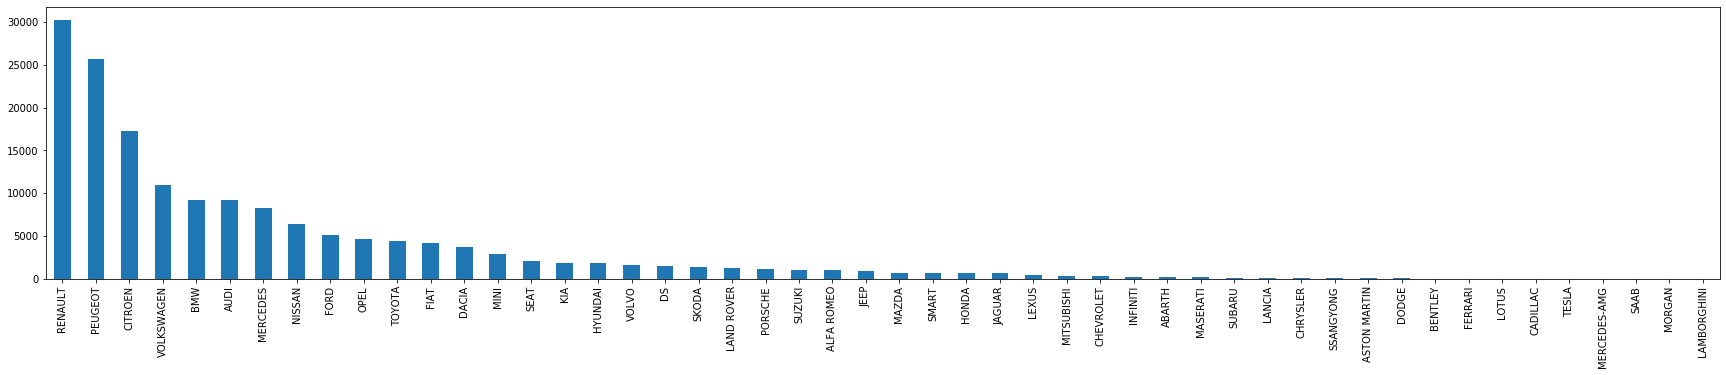

In [76]:
plt.figure(figsize=(30,5))
df_copy['Make'].value_counts().nlargest(50).plot.bar(x='index', y='Make')

###  Encoding `Makes`

Afin de pouvoir les rendre exploitable dans le modèle, nous allons remplacer chaque marque par un numéro distinct.

In [77]:
df_copy['Make'] = df_copy['Make'].str.upper()
to_match=''
to_match= df_copy["Make"]  

In [78]:
makes = list(df_copy['Make'].unique())
df_copy['Make'] = df_copy['Make'].map(lambda x : makes.index(x))

_____


#  Variable `Model`


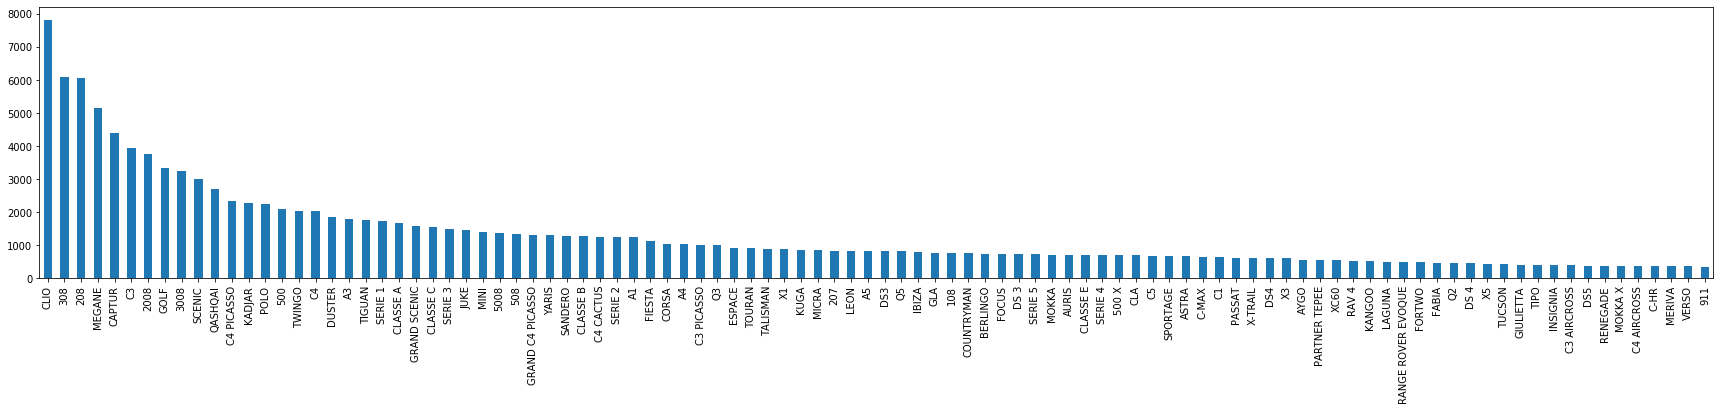

In [79]:
plt.figure(figsize=(30,5))
df_copy['Model'].value_counts().nlargest(100).plot.bar(x='index', y='Make')

### Encoding: conversion de `Modele` en valeur numérique

In [80]:
df_copy['Model'] = df_copy['Model'].str.upper()
to_match =  to_match +  ' '  +  df_copy["Model"] 

models = list(df_copy['Model'].unique())

df_copy['Model'] = df_copy['Model'].map(lambda x : models.index(x))

### Observations
Nous pouvons maintenant constater la fréquence de chaque modèle dans le dataset.

Sans surprise, les modèles des maques Renault, Peugoet et Citroën dominent le dataset.

Cela est peut-être dû au fait que ce dataset a principalement été édité par des Français qui achètent beeaucoup ces modèles. 

___

## Predict Cylinder

Comme nous l'avons constaté plus haut, beaucoup de véhicules n'ont pas de Cylindres de renseigné.
Trouver les valeurs exactes des cylindrés de ces véhicules peut être fastidieu et difficile à combler.

Néamoins, nous avons retenu une solution qui peut vraiment nous aider : la prédiction 

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [82]:
selection =  ['Price','Make' ,'Model', 'Model_year' , 'Power', 'Mileage', "gearbox_meca", 'gearbox_auto', 'Doors', 'Colors', "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 'Online_year', 'Online_month', 'Online_days', 'Ages', 'Horses']

In [83]:
# Feature Selection
X = complete[selection]
y = complete['Cylinder']

____

In [84]:
# TRAIN & TEST
cyl_rf, X_test, y_test =_generate_model(complete, selection, y )
cyl_y_pred = cyl_rf.predict(X_test)
cyl_y_pred.round()

array([3., 1., 2., ..., 2., 2., 2.])

In [85]:
# MAPE
_mape(y_test, cyl_y_pred)

3.531497705972713

In [86]:
# RESULTAT
no_cylinder_has_hors

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,gearbox_auto,...,Colors,Versions,Power,Doors,Online_year,Online_month,Online_days,Ages,Cylinder,Horses
1,57526,0,0,2015,0.195271,0,AUTOMATIQUE,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",1,...,1,(F16) XDRIVE30D 258 M SPORT BVA8,16,5,2018,4,3,3,nan,258
5,27956,0,1,2012,0.478160,0,AUTOMATIQUE,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S...",1,...,5,(F25) XDRIVE35D 313 SPORT DESIGN BVA8,20,5,2018,3,14,6,nan,313
9,69131,1,2,2015,0.197211,1,AUTOMATIQUE,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG...",1,...,9,(W205) 63 AMG S SPEEDSHIFT MCT AMG,40,4,2018,3,8,3,nan,63
25,23750,1,3,2016,0.099855,0,AUTOMATIQUE,12/06/2018 à 14h45,"modele: CLASSE B 2, version: II (2) 180 D SENS...",1,...,20,II (2) 180 D SENSATION 7G-DCT,5,5,2018,6,12,2,nan,180
32,10384,1,4,2006,0.973537,0,AUTOMATIQUE,13/08/2018 à 15h30,"modele: CLASSE R, version: COURT 320 CDI 4MATI...",1,...,22,COURT 320 CDI 4MATIC 7G-TRONIC,15,5,2018,8,13,12,nan,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166647,21030,9,26,2014,0.063737,1,AUTOMATIQUE,18/04/2018 à 9h38,"modele: , version: F55 COOPER 136CH PACK RED ...",1,...,734,F55 COOPER 136CH PACK RED HOT CHILI BVA,7,5,2018,4,18,4,nan,136
166654,18170,1,5,2014,0.262648,0,MÉCANIQUE,07/02/2018 à 0h29,"modele: CLASSE A 3, version: III 180 CDI SENSA...",0,...,6,III 180 CDI SENSATION,5,5,2018,2,7,4,nan,180
166666,17832,12,33,2017,0.066132,1,MÉCANIQUE,16/06/2018 à 1h32,"modele: , version: PURETECH 110 SO CHIC SS, pu...",0,...,4136,PURETECH 110 SO CHIC SS,5,3,2018,6,16,1,nan,110
166668,9930,7,16,2015,0.080468,1,MÉCANIQUE,18/03/2018 à 10h22,"modele: YARIS 3, version: III 69 VVT-I TENDANC...",0,...,27,III 69 VVT-I TENDANCE 5P,4,5,2018,3,18,3,nan,69


In [87]:
#### PREDICTION de données qui n'ont pas de Cylindre mais ont des chevaux
no_cylinder_has_hors = to_predict(no_cylinder_has_hors, selection, cyl_rf, 'Cylinder')

____

## Predict Cylinders for Data with  `NaN Cylinders` & `NaN Horses`

In [88]:
complete.shape

(128245, 29)

In [89]:
selection =  ['Price','Make' ,'Model', 'Model_year' , 'Power', 'Mileage', "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors', "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 'Online_year', 'Online_month', 'Online_days', 'Ages']

In [90]:
# TRAIN  & TEST
rf, X_test, y_test =_generate_model(complete, selection, y )
y_pred = rf.predict(X_test)
y_pred.round()

array([3., 2., 2., ..., 2., 2., 2.])

In [91]:
#  PREDICT NO CYLINDERS AND NO HORSES
no_cylinder_and_horse = to_predict(no_cylinder_and_horse, selection, rf, 'Cylinder')

In [92]:
_mape(y_test, y_pred)

4.449960887868358

In [93]:
# CONCATENATE RESULT
complete = complete.append([no_cylinder_and_horse, no_cylinder_has_hors, has_cyl_no_hors ])

_____
## PREDICT `HORSES`

In [94]:
selection =  ['Make' ,'Price','Model', 'Model_year' , 'Power', 'Mileage', "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors', "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 'Online_year', 'Online_month', 'Online_days', 'Ages', 'Cylinder']

In [95]:
no_horses = complete[ complete['Horses'].isna()]

In [96]:
complete = complete[ complete['Horses'].isna()==False]

In [97]:
complete['Horses'] = complete['Horses'].astype(int)

In [98]:
# SELECTION
y = complete['Horses']

In [99]:
# TRAIN & TEST
_rf, X_test, y_test =_generate_model(complete, selection, y)
y_pred = _rf.predict(X_test)
y_pred.round()

array([144.,  75.,  99., ..., 159., 117., 175.])

In [100]:
# MAPE
_mape(y_test, y_pred)

16.87656111446914

In [101]:
# Predict  Horses
no_horses = to_predict(no_horses, selection, _rf, 'Horses')

In [102]:
# CONCATENATE RESULT
complete = complete.append([no_horses])

In [103]:
#NEW
complete['Version'] = df_copy["Versions"]
complete["Gearbox"] = df_copy["Gearbox"]

In [104]:
# MERGE TO DF_COPY
df_copy = complete

____
# Variable `Doors`

Certaines de valeurs de la variable `Doors`, qui représentent le nombre de portes qu'a le véhicule, ont des valeurs égales à `0` ou `NaN`.
Comme l'avons fait précédement, nous allons prédire ces données manquantes.

In [105]:
has_doors= df_copy[df_copy['Doors']!=0]
no_doors= df_copy[df_copy['Doors']==0]

In [106]:
selection =  ['Make' , 'Price','Model', 'Model_year' , 'Power', 'Mileage',  'Colors', "gearbox_meca", 'gearbox_auto', "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 'Online_year', 'Online_month', 'Online_days', 'Ages', 'Cylinder']

In [107]:
y = has_doors['Doors']

In [108]:
_rf, X_test, y_test =_generate_model(has_doors, selection, y)
y_pred = _rf.predict(X_test)
y_pred.round()

array([5., 5., 5., ..., 5., 3., 5.])

In [109]:
# Predict  Horses
no_doors = to_predict(no_doors, selection, _rf, 'Horses')

In [110]:
_mape(y_test, y_pred)

8.601180910001968

In [111]:
# CONCATENATE
has_doors = has_doors.append([no_doors])


In [113]:
# FINAL REPLACE DF_COPY
df_copy = has_doors

____
# Matrice de Corrélation

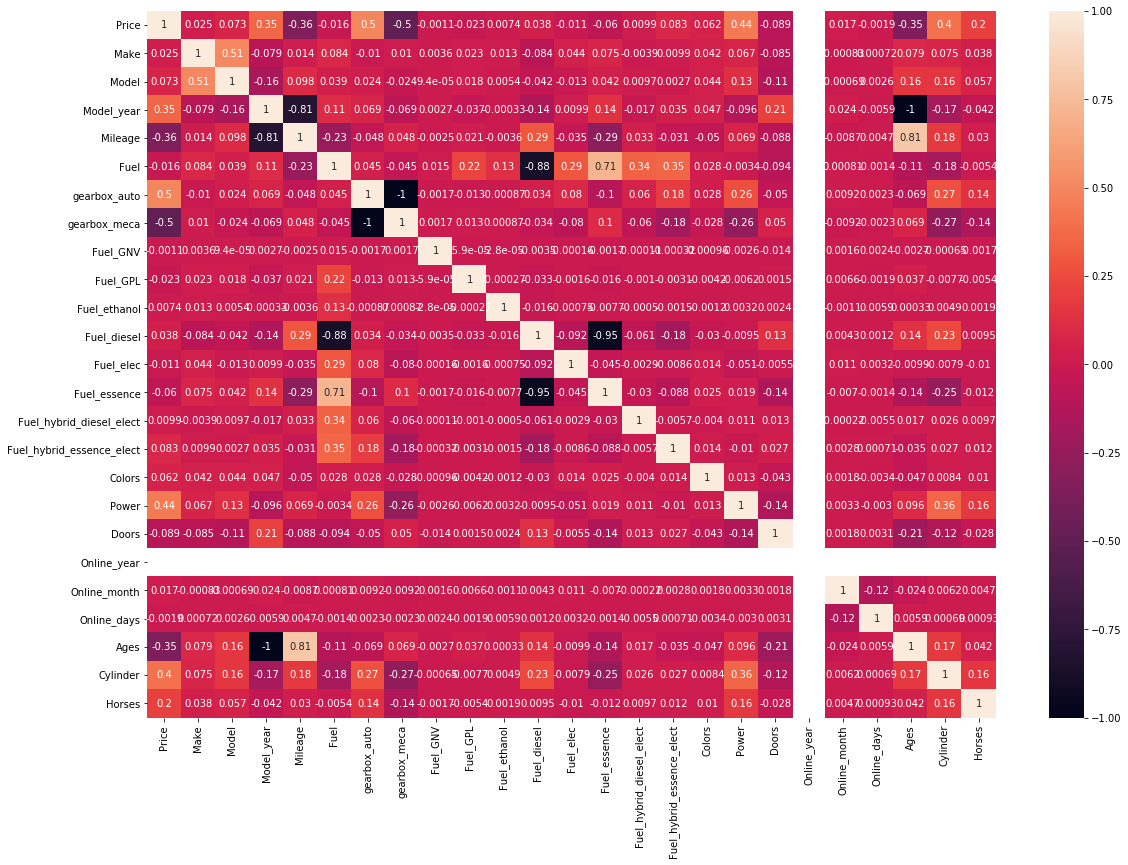

In [114]:
corrMatrix =df_copy.corr()
plt.figure(figsize=(19,13))
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Observations
Ce graphique représente le lien de corrélation entre les variables. Nous pouvons constater : 

- Des corrélations positives entre le `Price ` et les variables `Mode_year`, `Gearbox_Auto`, `Power`, `Cylinder` et `Horses`,
- Des corrélations négatives entre `Price` et les variables `Mileage`  et `Ages`

_____
## VECTORISATION `OPTIONS` (Je n'ai pas réussi cette étape)

____
# New_price : Fuzzy Matching

- Afin de pouvoir compléter nos données, j'ai dû scrappé dans un notebook parallèle le site http://autoplus.fr pour récupérer le prix des véhicules neufs.
- Les données récupérées sont enregistrées dans le CSV `prix-voiture.csv`
- Nous allons maintenant devoir faire un matching entre ces nouvelles données et notre dataset principal.
- Pour cela je vais utiliser la librairie `FUZZYWUZZY`, plus principalement la méthode `token_set_ratio` régler le problème

In [115]:
# NOUVELLES
df_copy['New_price'] = 0
df_copy['Score'] = 0

In [116]:
df_copy['Car_matched'] = ''

In [117]:
to_match

0             PEUGEOT 308
1                  BMW X6
2                AUDI RS6
3                 FORD KA
4               FIAT TIPO
               ...       
166690            AUDI A4
166691    VOLKSWAGEN GOLF
166692        FORD FIESTA
166693      SKODA OCTAVIA
166694     RENAULT KOLEOS
Length: 162738, dtype: object

In [153]:
df_copy["To_match"] =to_match+ ' ' +  df_copy["Versions"]  +  ' ('  + df_copy['Doors'].astype(str) +  'P.) '   +   df_copy["Gearbox"]

In [119]:
df_copy["_Make"] = to_match.map(lambda x : x.split()[0].strip() )
df_copy["_Model"] = to_match.map(lambda x : x.split()[1].strip() )

In [120]:
# DONNEE SCRAPÉE
df2 =  pd.read_csv('prix-voiture.csv')

#MAKE MODEL
df2['Marque_Modele'] = df2['Marque_Modele'].str.upper()

#VERSION
df2['VERSION'] = df2['VERSION'].str.upper()

#GEARBOX
df2['Boite_de_vitesse'][ df2['Boite_de_vitesse']=='Manuelle']= 'mécanique'
df2['Boite_de_vitesse'] = df2['Boite_de_vitesse'].str.upper()

#VARIABLE A MATCHER AVEC DF_COPY
df2["To_match"] = df2["Marque_Modele"] + ' ' +  df2["VERSION"] + ' ' +   df2["Boite_de_vitesse"]

In [121]:
df2['Make']= df2['Marque_Modele'].map(lambda x : x.split()[0].strip() )
df2['Model']= df2['Marque_Modele'].map(lambda x : x.split()[1].strip() )

In [122]:
df2['Make'] = df2['Make'].str.strip()

In [155]:
df3 = pd.read_csv('df_copy4.csv')
df_copy = df3

In [171]:
not_matched = df_copy[ df_copy['New_price']==0 ]
not_matched

,Unnamed: 0,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,...,Horses,Version,To_match,New_price,Score,Make_model,_Make,_Model,car_matched,Car_matched
53794,70341,8006,48,387,2007,0.410318,0,AUTOMATIQUE,13/04/2018 à 19h42,"modele: 9-3 (2E GENERATION), version: II 1.9 T...",...,150.000000,II 1.9 TID 150 LINEAR SPORT BVA,SAAB 9-3 II 1.9 TID 150 LINEAR SPORT BVA (4P.)...,0,-1,SAAB 9-3,SAAB,9-3,nan,nan
53867,70447,19152,24,399,2013,0.341386,0,AUTOMATIQUE,27/02/2018 à 16h10,"modele: THEMA 2, version: II 3.0 MULTIJET II 2...",...,239.000000,II 3.0 MULTIJET II 239 EXECUTIVE,LANCIA THEMA II 3.0 MULTIJET II 239 EXECUTIVE ...,0,-1,LANCIA THEMA,LANCIA,THEMA,nan,nan
54316,71043,6643,24,114,2013,0.342446,1,MÉCANIQUE,03/03/2018 à 7h40,"modele: YPSILON 3, version: III 1.2 8V 69 STOP...",...,69.000000,III 1.2 8V 69 STOP&START PLATINUM,LANCIA YPSILON III 1.2 8V 69 STOP&START PLATIN...,0,-1,LANCIA YPSILON,LANCIA,YPSILON,nan,nan
54394,71141,8882,34,282,2011,0.704134,0,AUTOMATIQUE,20/05/2018 à 6h48,"modele: ORLANDO, version: 2.0 VCDI 163 LTZ BVA...",...,163.000000,2.0 VCDI 163 LTZ BVA,CHEVROLET ORLANDO 2.0 VCDI 163 LTZ BVA (5P.) A...,0,-1,CHEVROLET ORLANDO,CHEVROLET,ORLANDO,nan,nan
54568,71355,9900,24,320,2013,0.262103,0,MÉCANIQUE,16/07/2018 à 6h18,"modele: MUSA, version: (2) 1.3 MULTIJET 95 DPF...",...,95.000000,(2) 1.3 MULTIJET 95 DPF STOP&START VIA VENETO,LANCIA MUSA (2) 1.3 MULTIJET 95 DPF STOP&START...,0,-1,LANCIA MUSA,LANCIA,MUSA,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162733,165089,5539,12,30,2010,0.497852,1,MÉCANIQUE,29/07/2018 à 3h44,"modele: COLT 7, version: VII 1.3 INFORM, puiss...",...,4.322971,VII 1.3 INFORM,MITSUBISHI COLT VII 1.3 INFORM (0P.) MÉCANIQUE,0,0,MITSUBISHI COLT,MITSUBISHI,COLT,nan,nan
162734,165474,5823,20,37,2008,0.256642,0,MÉCANIQUE,03/04/2018 à 20h47,"modele: AYGO, version: 1.4 D 5P, puissance_fis...",...,4.307992,1.4 D 5P,TOYOTA AYGO 1.4 D 5P (0P.) MÉCANIQUE,0,0,TOYOTA AYGO,TOYOTA,AYGO,nan,nan
162735,165539,6997,8,12,2010,0.406253,0,MÉCANIQUE,06/06/2018 à 20h18,"modele: , version: 1.6 TDI 75CV FAP TREND LINE...",...,4.780718,1.6 TDI 75CV FAP TREND LINE,VOLKSWAGEN POLO 1.6 TDI 75CV FAP TREND LINE (0...,0,0,VOLKSWAGEN POLO,VOLKSWAGEN,POLO,nan,nan
162736,165979,50299,45,394,2008,0.075868,1,MÉCANIQUE,15/08/2018 à 19h54,"modele: 2 ELEVEN, version: 1.8 255, puissance_...",...,2.415665,1.8 255,LOTUS 2 ELEVEN 1.8 255 (0P.) MÉCANIQUE,0,0,LOTUS 2 ELEVEN,LOTUS,2,nan,nan


In [168]:
from fuzzywuzzy import fuzz

In [169]:
# FONCTION FUZZY WUZZY MATCHING
def matching(car, _make, _model):
    score = -1
    price=0
    car_match=0
    matched = None

    for i in range(df2.shape[0]):
        if _make == df2['Make'][i]:
                sc = fuzz.token_set_ratio(car, df2['To_match'][i])
                if sc > score:
                    matched =  df2['To_match'][i]
                    score = sc
                    price = df2['PRIX_Neuf'][i]
    
    return( price, score, matched )

In [170]:
# APPEL DE LA FONCTION POUR CHAQUE VOITURE DE DF_COPY
for j in not_matched.index :
    _make  = df_copy['_Make'][j]
    _model = df_copy['_Model'][j]
    mark_mod = df_copy['Make_model'][j]
    matched = None
    
    df_copy['New_price'][j], df_copy['Score'][j], matched = matching( df_copy['To_match'][j],  _make, _model)
    
#    if  matched is not None:
#        print(df_copy['To_match'][j], ' = ',  matched)

KeyboardInterrupt: 

In [4]:
df_predicted = pd.read_csv('df_copy6.csv')

In [5]:
df_copy = df_predicted

------
## `RandomForestRegressor`

À ce stade nos variables sont prêtes, nous pouvons commencer à travailler sur la modélisation finale.
Pour cela, j'ai choisi le modèle `RandomForestRegressor` qui est basé sur des Arbres de décision.

In [6]:
df_copy = df_copy [df_copy['New_price']!=0]

In [7]:
df_copy.dtypes

Unnamed: 0                     int64
Unnamed: 0.1                   int64
Price                          int64
Make                           int64
Model                          int64
Model_year                     int64
Mileage                      float64
Fuel                           int64
Gearbox                       object
Online                        object
Description                   object
gearbox_auto                   int64
gearbox_meca                   int64
Fuel_GNV                       int64
Fuel_GPL                       int64
Fuel_ethanol                   int64
Fuel_diesel                    int64
Fuel_elec                      int64
Fuel_essence                   int64
Fuel_hybrid_diesel_elect       int64
Fuel_hybrid_essence_elect      int64
Colors                         int64
Versions                      object
Power                          int64
Doors                          int64
Online_year                    int64
Online_month                   int64
O

In [8]:
to_drop = ['Description', 'Online', 'Gearbox','Fuel',  'Versions', 'Version', 'Make_model', 'Score',"To_match", "_Make", '_Model', 'Score', 'car_matched', 'Car_matched', 'Unnamed: 0', 'Unnamed: 0.1' ]

In [9]:
df_copy = df_copy.drop(columns=to_drop)

In [10]:
y = df_copy['Price']
X = df_copy.drop(columns=['Price'])

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [13]:
# TRAINING SET
X_train.shape, y_train.shape, 

((123160, 24), (123160,))

In [14]:
# TEST SET
X_test.shape, y_test.shape

((30791, 24), (30791,))

In [15]:
rf = RandomForestRegressor(n_estimators=213, min_samples_leaf=1, min_samples_split=2, n_jobs=-1, max_depth=40)

In [16]:
scores = cross_val_score(rf, X_train,y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.95


In [247]:
y_pred = rf.predict(X_test)

## MAPE

In [248]:
N = len(y_pred)
mape = (1/N) * sum(abs((y_test - y_pred)/y_test)) * 100
mape

7.81391069056348

------

# XGBRegressor

In [249]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold

In [250]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [336]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.555, learning_rate = 0.044, max_depth = 45, alpha = 10, n_estimators = 140)

In [337]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.555, gamma=0,
             importance_type='gain', learning_rate=0.044, max_delta_step=0,
             max_depth=45, min_child_weight=1, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [338]:
xg_preds = xg_reg.predict(X_test)

## MAPE

In [339]:
N = len(xg_preds)
mape = (1/N) * sum(abs((y_test - xg_preds)/y_test)) * 100
mape

7.0020519730078705

##  CROSS VALIDATION

In [290]:
scores = cross_val_score(xg_reg, X_train,y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.96


Comme nous pouvons le constater la perfomance la plus intéressante est réalisé par XGBoostRegressoravec 7% d'erreurs moyens et un résultat de cross validation de 96%

-----
# RESULTATS

#### MODEL : RandomForestRegressor

`V1 = ['Make' ,'Model', 'Model_year' , 'Mileage', 'Fuel', 'Power', 'Doors', "Gearbox"]`


```
MAPE = 10.119949686211395
```


____

#### MODEL : RandomForestRegressor

`V2  = ['Make' ,'Model', 'Model_year' , 'Mileage', 'Fuel', 'Power', 'Doors', "gearbox_meca" , "gearbox_auto"]`

```
MAPE = 10.121793211480894


```

____
#### MODEL : RandomForestRegressor

`V3 = ['Make' ,'Model', 'Model_year' , 'Mileage', "gearbox_meca", 'gearbox_auto', 'Power', 'Doors', "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect"]`

```

MAPE = 10.123539197944757
```

___

#### MODEL : RandomForestRegressor

```V4 =  ['Make' ,'Model', 'Model_year' , 'Mileage', "gearbox_meca", 'gearbox_auto', 'Doors', "Fuel_GNV","Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 'Online_year','Online_month', 'Online_days', 'Ages']```


```

MAPE = 12.564634678533833
```


____

-  MODEL : RandomForestRegressor

`V5 =   ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses'] `

```
MAPE = 9.12
```

---------

#### MODEL : RandomForestRegressor
-  À Partir de la V6  j'ai changé les filtres de `Price`  pour les encadrer de manière suivante : 400 € à 125000 €

`V6 =   ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses'] `


```
MAPE = 8.96
```

-----
#### MODEL : RandomForestRegressor
-  Ajout du Filtrage : `Mileage` < `200000`

`V6 =   ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses'] `


```
MAPE = 8.76
```

-----
#### MODEL : RandomForestRegressor
-  Ajout du Filtrage :  `2000` < `Model year` < `2020`

`V6 =   ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses'] `


```
MAPE = 8.55
```
-----
#### MODEL : RandomForestRegressor
- Ajout de  `New_Price`

`V7 = ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses', 'New_Price']`

```
MAPE = 7.81
```

-----

#### MODEL : XGBoostRegressor  

`V8 = ['Make' ,'Model', 'Model_year' , 'Power', 'Mileage', 
              "gearbox_meca", 'gearbox_auto', 'Doors',  'Colors',
              "Fuel_GNV", "Fuel_GPL","Fuel_ethanol","Fuel_diesel","Fuel_elec","Fuel_essence","Fuel_hybrid_diesel_elect","Fuel_hybrid_essence_elect", 
              'Online_year', 'Online_month', 'Online_days', 'Ages', 
              'Cylinder', 'Horses', 'New_Price']`

```
MAPE = 7.00
```
